# 数据集：Wine Reviews (winemag-data-130k-v2.csv.csv)

## 一、 对数据集进行处理，转换成适合关联规则挖掘的形式

### 1. 首先读取数据集中的数据，并打印基本信息

In [1]:
import pandas as pd
import numpy as np

originData = pd.read_csv('winemag-data-130k-v2.csv',index_col=0)
originData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


### 2. 打印数据集的前5行数据

In [2]:
originData.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### 3. 对原始数据进行处理，删除原始数据中的唯一值属性和缺失值较多的属性，数值属性使用众数填充缺失值

In [3]:
#删除原始数据中的唯一值的属性,同时由于region_2缺失值较多，删掉region_2
data = originData.drop(columns = ['description','designation','region_2','title'])

#数值属性value存在缺失值，使用中位数填充
data.price.fillna(data.price.mode().values[0], inplace=True)

#非数值属性删除原始数据中的存在缺失值的行
# data.dropna(inplace=True)
# data.reset_index(inplace=True)
# data.drop(columns = ['index'],inplace=True)

#非数值属性使用上一个值填充缺失值
data.fillna(method='pad',inplace=True)
data.head()

,country,points,price,province,region_1,taster_name,taster_twitter_handle,variety,winery
0,Italy,87,20.0,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,White Blend,Nicosia
1,Portugal,87,15.0,Douro,Etna,Roger Voss,@vossroger,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,@paulgwine,Riesling,St. Julian
4,US,87,65.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Pinot Noir,Sweet Cheeks


### 4. 将数据转化成Ariori算法便于处理的形式，便于查找频繁项集和关联规则，主要将DataFrame中的数据转为frozenset和list集合

In [4]:
#参考代码：https://github.com/mattzheng/AprioriDemo/blob/master/apriori2.py
def dataFromDataFrame(fname):
    """Function which reads from the file and yields a generator"""
    for i in range(len(fname)):
        record = frozenset(fname.loc[i,:])
        yield record

def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    # Generate 1-itemSets ...
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))              # Generate 1-itemSets
    return itemSet, transactionList

#将DataFrame转为frozenset
inFile = dataFromDataFrame(data)
itemSet, transactionList = getItemSetTransactionList(inFile)
#print('complete')

## 二、关联规则挖掘过程

### 1. 几个基本概念：

关联规则（Association Rules）：暗示两个物品之间可能存在很强的关系。形如A->B的表达式，规则A->B的度量包括支持度和置信度

支持度$ support(A \Rightarrow B) = P(A \cup B) $，指的是事件A和事件B同时发生的概率。

置信度$ confidence(A \Rightarrow B) = P(B | A) = \frac{P(A \cup B)}{P(A)}$,指的是发生事件A的基础上发生事件B的概率。

同时满足最小支持度阈值和最小置信度阈值的规则称为强规则。

如果事件A中包含k个元素，那么称这个事件A为k项集，并且事件A满足最小支持度阈值的事件称为频繁k项集。

### 2. 挖掘过程：

第一，找出所有的频繁项集；

第二，由频繁项集产生强规则。

### 3. 使用Ariori算法找出频繁项集

Apriori算法：使用候选项集找频繁项集

   Apriori算法是一种最有影响的挖掘布尔关联规则频繁项集的算法。其核心是基于两阶段频集思想的递推算法。该关联规则在分类上属于单维、单层、布尔关联规则。在这里，所有支持度大于最小支持度的项集称为频繁项集，简称频集。
   
   Apriori原理：如果某个项集是频繁的，那么它的所有子集也是频繁的。该定理的逆反定理为：如果某一个项集是非频繁的，那么它的所有超集（包含该集合的集合）也是非频繁的。Apriori原理的出现，可以在得知某些项集是非频繁之后，不需要计算该集合的超集，有效地避免项集数目的指数增长，从而在合理时间内计算出频繁项集。

### 4. Ariori算法实现

In [5]:
#参考代码：https://github.com/mattzheng/AprioriDemo/blob/master/apriori2.py

from itertools import chain, combinations
from collections import defaultdict

"""
构建函数输入的内容有三样：
itemSet：数据单元的frozenset集合
transactionList：所有数据的list集合
minSupport：最小支持度阈值，常在0.1-0.2之间
minConfidence：最小置信度阈值，0.5-0.7之间
minLift：最小Lift指标
tuples：元组

执行runApriori后输出两样内容：
    items，支持度表，形式为：(tuple, support)，一个词的支持度、一对词的支持度【无指向】
    rules，置信度表，形式为((pretuple, posttuple), confidence)，（起点词，终点词），置信度【有指向】
"""
class MyArioir:
    resRules = []
    resItems = []
    resEvaluation = []
    def __init__(self, itemSet, transactionList, minSupport, minConfidence, minLift = 0,tuples = 2):
        self.itemSet = itemSet
        self.transactionList = transactionList
        self.minSupport = minSupport
        self.minConfidence = minConfidence
        self.minLift = minLift
        self.tuples = tuples
    
    @classmethod
    def buildMyArioir(cls, data, minSupport, minConfidence, minLift = 0,tuples =2):
        inFile = cls.dataFromDataFrame(data)
        itemSet, transactionList = cls.getItemSetTransactionList(inFile)
        return cls(itemSet, transactionList, minSupport, minConfidence, minLift, tuples)
    
    def subsets(self, arr):
        """ Returns non empty subsets of arr"""
        return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])

    def returnItemsWithMinSupport(self, currentLSet, freqSet):
        """calculates the support for items in the itemSet and returns a subset
        of the itemSet each of whose elements satisfies the minimum support"""
        _itemSet = set()
        localSet = defaultdict(int)
        
        for item in currentLSet:
            #print(item)
            for transaction in self.transactionList:
                if item.issubset(transaction):
                    freqSet[item] += 1
                    localSet[item] += 1
            for item, count in list(localSet.items()):
                support = float(count)/len(self.transactionList)
                if support >= self.minSupport:
                    _itemSet.add(item)
        
        return _itemSet


    def joinSet(self,currentLSet, length):
        """Join a set with itself and returns the n-element itemsets"""
        return set([i.union(j) for i in currentLSet for j in currentLSet if len(i.union(j)) == length])
    
    def runApriori(self):
        """
        run the apriori algorithm. data_iter is a record iterator
        Return both:
         - items (tuple, support)
         - rules ((pretuple, posttuple), confidence)
        """
        freqSet = defaultdict(int)
        largeSet = dict()
        # Global dictionary which stores (key=n-itemSets,value=support)
        # which satisfy minSupport
        assocRules = dict()
        # Dictionary which stores Association Rules

        oneCSet = self.returnItemsWithMinSupport(self.itemSet,freqSet)

        currentLSet = oneCSet
        k = 2
        while(currentLSet != set([])):
            largeSet[k-1] = currentLSet
            currentLSet = self.joinSet(currentLSet, k)
            currentCSet = self.returnItemsWithMinSupport(currentLSet,freqSet)
            currentLSet = currentCSet
            k = k + 1

        def getSupport(item):
            """local function which Returns the support of an item"""
            return float(freqSet[item])/len(self.transactionList)
    
        #print('Calculation the tuple words and support ... ')
        toRetItems = []
        for key, value in list(largeSet.items()):
            toRetItems.extend([(tuple(item), getSupport(item)) for item in value])

        toRetRules = []
        #print('Calculation the pretuple words and confidence ... ')
        for key, value in list(largeSet.items())[1:]:
            for item in value:
                if len(item) <= self.tuples:
                    _subsets = map(frozenset, [x for x in self.subsets(item)])
                    for element in _subsets:
                        remain = item.difference(element)
                        if len(remain) > 0:
                            confidence = getSupport(item)/getSupport(element)
                            #lift = getSupport(item)/( getSupport(element) * getSupport(remain))
                            lift = confidence / getSupport(remain)
                            self_support = getSupport(item)
                            if self_support >= self.minSupport:
                                if confidence >= self.minConfidence:
                                    if lift >= self.minLift:
                                        toRetRules.append(((tuple(element), tuple(remain)),tuple(item),self_support,confidence,lift))
                                        
                                        item_support = getSupport(item)
                                        a_support = getSupport(element)
                                        b_support = getSupport(remain)
                                        
                                        allconf = item_support / max(a_support,b_support);
                                        jaccard = item_support / (a_support + b_support - item_support)
                                        cosine = item_support / ((a_support * b_support) ** 0.5)
                                        kulczynski = 0.5 * (item_support / a_support + item_support / b_support)
                                        maxconf = max(a_support / item_support, b_support / item_support)
                                        self.resEvaluation.append(((tuple(element), tuple(remain)),tuple(item),
                                                                   lift,allconf,jaccard,cosine,kulczynski,maxconf))
        self.resRules = toRetRules
        self.resItems = toRetItems
        return toRetItems, toRetRules
    
    @staticmethod
    def dataFromDataFrame(fname):
        """Function which reads from the file and yields a generator"""
        for i in range(len(fname)):
            record = frozenset(fname.loc[i,:])
            yield record
    
    @staticmethod
    def getItemSetTransactionList(data_iterator):
        transactionList = list()
        itemSet = set()
        print('Generate 1-itemSets ... ')
        for record in data_iterator:
            transaction = frozenset(record)
            transactionList.append(transaction)
            for item in transaction:
                itemSet.add(frozenset([item]))              # Generate 1-itemSets
        return itemSet, transactionList
    
    def printResults(self):
        """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
        print ("\n--------------------频繁项集及其支持度--------------------")
        for item, support in self.resItems:
            print ("    %s : %.3f" % (str(item), support))
        
        print ("\n--------------------关联规则及其确信度--------------------")
        for rule, item, self_support, confidence, lift in self.resRules:
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), confidence))
            
    def printFrequenceSet(self):
        res = {}
        for item, support in self.resItems:
            res[item] = support
        
        print ("\n--------------------频繁项集及其支持度(支持度从大到小排序)--------------------") 
        for item, support in sorted(res.items(), key=lambda d: d[1], reverse = True):
            print ("    %s : %.3f" % (str(item), support))
            
    def printSupport(self):
        res = {}
        for rule, item, self_support, confidence, lift in self.resRules:
            pre, post = rule
            res[rule] = self_support
        
        print ("\n--------------------关联规则及其支持度(支持度从大到小排序)--------------------")
        for rule, self_support in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), self_support))
    
    def printRules(self):
        res = {}
        for rule, item, self_support, confidence, lift in self.resRules:
            pre, post = rule
            res[rule] = self_support
        
        print ("\n--------------------关联规则及其支持度(支持度从大到小排序)--------------------")
        for rule, self_support in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), self_support))
        
    def printConfidence(self):
        res = {}
        for rule, item, self_support, confidence, lift in self.resRules:
            pre, post = rule
            res[rule] = confidence
        
        print ("\n--------------------关联规则及确信度(确信度从大到小排序)--------------------")
        for rule, confidence in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), confidence))
            
    def printLift(self):
        res = {}
        for rule, item, self_support, confidence, lift in self.resRules:
            pre, post = rule
            res[rule] = lift
        
        print ("\n--------------------关联规则及Lift(Lift从大到小排序)--------------------")
        for rule, lift in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), lift))
            

### 5. 使用Ariori算法找出频繁项集

In [6]:
minSupport = 0.1
minConfidence = 0.5
minLift = 0.0

#方法一：调用获得
myArioir = MyArioir(itemSet, transactionList, minSupport, minConfidence, minLift, tuples = 2)
items, rules = myArioir.runApriori()
myArioir.printFrequenceSet()


--------------------频繁项集及其支持度(支持度从大到小排序)--------------------
    ('US',) : 0.420
    ('California',) : 0.284
    ('US', 'California') : 0.279
    ('@vossroger',) : 0.261
    ('Roger Voss',) : 0.251
    ('Roger Voss', '@vossroger') : 0.251
    ('@wineschach',) : 0.174
    ('France',) : 0.170
    ('Michael Schachner',) : 0.166
    ('@wineschach', 'Michael Schachner') : 0.166
    ('Italy',) : 0.150
    ('Roger Voss', 'France') : 0.143
    ('@vossroger', 'France') : 0.143
    ('Roger Voss', '@vossroger', 'France') : 0.143
    (88,) : 0.133
    (87,) : 0.131
    (90,) : 0.123
    (20.0,) : 0.123
    ('@paulgwine\xa0',) : 0.114
    ('Paul Gregutt',) : 0.110
    ('@paulgwine\xa0', 'Paul Gregutt') : 0.110
    ('Pinot Noir',) : 0.102


In [7]:
#方法二：通过原始的DataFrame构建MyArioir类，并获得频繁项集

myArioir2 = MyArioir.buildMyArioir(data, minSupport, minConfidence, minLift, tuples = 2)
#items, rules = myArioir2.runApriori()
#myArioir2.printResults()

Generate 1-itemSets ... 


## 三、导出关联规则，并计算其支持度和置信度

### 1. 关联规则（Association Rules）：暗示两个物品之间可能存在很强的关系。形如A->B的表达式，规则A->B的度量包括支持度和置信度

In [8]:
#输出关联规则及其支持度(按照支持度从大到小排序)
myArioir.printRules()


--------------------关联规则及其支持度(支持度从大到小排序)--------------------
    ('US',) ==> ('California',) : 0.279
    ('California',) ==> ('US',) : 0.279
    ('Roger Voss',) ==> ('@vossroger',) : 0.251
    ('@vossroger',) ==> ('Roger Voss',) : 0.251
    ('@wineschach',) ==> ('Michael Schachner',) : 0.166
    ('Michael Schachner',) ==> ('@wineschach',) : 0.166
    ('Roger Voss',) ==> ('France',) : 0.143
    ('France',) ==> ('Roger Voss',) : 0.143
    ('@vossroger',) ==> ('France',) : 0.143
    ('France',) ==> ('@vossroger',) : 0.143
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.110
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 0.110


### 2. 支持度$ support(A \Rightarrow B) = P(A \cup B) $，指的是事件A和事件B同时发生的概率。

In [9]:
#输出关联规则及其支持度(支持度从大到小排序)
myArioir.printSupport()


--------------------关联规则及其支持度(支持度从大到小排序)--------------------
    ('US',) ==> ('California',) : 0.279
    ('California',) ==> ('US',) : 0.279
    ('Roger Voss',) ==> ('@vossroger',) : 0.251
    ('@vossroger',) ==> ('Roger Voss',) : 0.251
    ('@wineschach',) ==> ('Michael Schachner',) : 0.166
    ('Michael Schachner',) ==> ('@wineschach',) : 0.166
    ('Roger Voss',) ==> ('France',) : 0.143
    ('France',) ==> ('Roger Voss',) : 0.143
    ('@vossroger',) ==> ('France',) : 0.143
    ('France',) ==> ('@vossroger',) : 0.143
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.110
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 0.110


### 3. 置信度$ confidence(A \Rightarrow B) = P(B | A) = \frac{P(A \cup B)}{P(A)}$,指的是发生事件A的基础上发生事件B的概率。

In [10]:
#输出关联规则及其置信度(置信度从大到小排序)
myArioir.printConfidence()


--------------------关联规则及确信度(确信度从大到小排序)--------------------
    ('Michael Schachner',) ==> ('@wineschach',) : 1.000
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 1.000
    ('Roger Voss',) ==> ('@vossroger',) : 1.000
    ('California',) ==> ('US',) : 0.983
    ('@vossroger',) ==> ('Roger Voss',) : 0.962
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.962
    ('@wineschach',) ==> ('Michael Schachner',) : 0.952
    ('France',) ==> ('Roger Voss',) : 0.844
    ('France',) ==> ('@vossroger',) : 0.844
    ('US',) ==> ('California',) : 0.665
    ('Roger Voss',) ==> ('France',) : 0.571
    ('@vossroger',) ==> ('France',) : 0.549


## 四、对规则进行评价，使用了lift,allconf,jaccard,cosine,kulczynski,maxconf指标

### 1. 计算关联规则的Lift指标

Lift 是用于判断事件的独立与相关性的，在一定程度上非常类似概率论中证明两个事件独立性的方法。其具体定义如下：

$$
Lift(X \Rightarrow Y) = \frac{support(X \cup Y)}{support(X) \times support(Y)}
$$

$$
Lift(X \Rightarrow Y) = 
\begin{cases}
>1,  & \text{正相关} \\
=1, & \text{独立} \\
< 1, & \text{负相关}
\end{cases}
$$

实际运用中，考虑正相关和负相关，同时$ Lift(X \Rightarrow Y) = Lift(Y \Rightarrow X)$。

In [11]:
#输出关联规则及其lift(lift从大到小排序)
myArioir.printLift()


--------------------关联规则及Lift(Lift从大到小排序)--------------------
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 8.757
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 8.757
    ('@wineschach',) ==> ('Michael Schachner',) : 5.739
    ('Michael Schachner',) ==> ('@wineschach',) : 5.739
    ('Roger Voss',) ==> ('@vossroger',) : 3.828
    ('@vossroger',) ==> ('Roger Voss',) : 3.828
    ('Roger Voss',) ==> ('France',) : 3.358
    ('France',) ==> ('Roger Voss',) : 3.358
    ('@vossroger',) ==> ('France',) : 3.230
    ('France',) ==> ('@vossroger',) : 3.230
    ('US',) ==> ('California',) : 2.344
    ('California',) ==> ('US',) : 2.344


### 2. Allconf指标

$$
Allconf(X \Rightarrow Y) = \frac{support(X \cup Y)}{max\{support(X), support(Y)\}}
$$

In [12]:
def printAllconf(resEvaluation):
        res = {}
        for rule, item, lift,allconf, jaccard, cosine, kulczynski, maxconf in resEvaluation:
            pre, post = rule
            res[rule] = allconf
        
        print ("\n--------------------关联规则及其allconf(allconf从大到小排序)--------------------")
        for rule, allconf in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), allconf))

printAllconf(myArioir.resEvaluation)


--------------------关联规则及其allconf(allconf从大到小排序)--------------------
    ('Roger Voss',) ==> ('@vossroger',) : 0.962
    ('@vossroger',) ==> ('Roger Voss',) : 0.962
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.962
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 0.962
    ('@wineschach',) ==> ('Michael Schachner',) : 0.952
    ('Michael Schachner',) ==> ('@wineschach',) : 0.952
    ('US',) ==> ('California',) : 0.665
    ('California',) ==> ('US',) : 0.665
    ('Roger Voss',) ==> ('France',) : 0.571
    ('France',) ==> ('Roger Voss',) : 0.571
    ('@vossroger',) ==> ('France',) : 0.549
    ('France',) ==> ('@vossroger',) : 0.549


### 3. Jaccard指标
$$
Jaccard(X \Rightarrow Y) = \frac{support(X \cup Y)}{support(X) + support(Y) - support(X \cup Y)}
$$

In [13]:
def printJaccard(resEvaluation):
        res = {}
        for rule, item, lift,allconf, jaccard, cosine, kulczynski, maxconf in resEvaluation:
            pre, post = rule
            res[rule] = jaccard
        
        print ("\n--------------------关联规则及其jaccard(jaccard从大到小排序)--------------------")
        for rule, jaccard in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), jaccard))
            
printJaccard(myArioir.resEvaluation)


--------------------关联规则及其jaccard(jaccard从大到小排序)--------------------
    ('Roger Voss',) ==> ('@vossroger',) : 0.962
    ('@vossroger',) ==> ('Roger Voss',) : 0.962
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.962
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 0.962
    ('@wineschach',) ==> ('Michael Schachner',) : 0.952
    ('Michael Schachner',) ==> ('@wineschach',) : 0.952
    ('US',) ==> ('California',) : 0.658
    ('California',) ==> ('US',) : 0.658
    ('Roger Voss',) ==> ('France',) : 0.516
    ('France',) ==> ('Roger Voss',) : 0.516
    ('@vossroger',) ==> ('France',) : 0.499
    ('France',) ==> ('@vossroger',) : 0.499


### 4. Cosine指标
$$
Cosine(X \Rightarrow Y) = \frac{support(X \cup Y)}{\sqrt{support(X) \times support(Y)}}
$$

In [14]:
def printCosine(resEvaluation):
        res = {}
        for rule, item, lift,allconf, jaccard, cosine, kulczynski, maxconf in resEvaluation:
            pre, post = rule
            res[rule] = cosine
        
        print ("\n--------------------关联规则及其cosine(cosine从大到小排序)--------------------")
        for rule, cosine in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), cosine))

printCosine(myArioir.resEvaluation)


--------------------关联规则及其cosine(cosine从大到小排序)--------------------
    ('Roger Voss',) ==> ('@vossroger',) : 0.981
    ('@vossroger',) ==> ('Roger Voss',) : 0.981
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.981
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 0.981
    ('@wineschach',) ==> ('Michael Schachner',) : 0.976
    ('Michael Schachner',) ==> ('@wineschach',) : 0.976
    ('US',) ==> ('California',) : 0.809
    ('California',) ==> ('US',) : 0.809
    ('Roger Voss',) ==> ('France',) : 0.694
    ('France',) ==> ('Roger Voss',) : 0.694
    ('@vossroger',) ==> ('France',) : 0.681
    ('France',) ==> ('@vossroger',) : 0.681


### 5. Kulczynski指标
$$
Kulczynski(X \Rightarrow Y) = \frac{1}{2}\left(\frac{support(X \cup Y)}{support(X)} + \frac{support(X \cup Y)}{support(Y)}\right)
$$

In [15]:
def printKulczynski(resEvaluation):
        res = {}
        for rule, item, lift,allconf, jaccard, cosine, kulczynski, maxconf in resEvaluation:
            pre, post = rule
            res[rule] = kulczynski
        
        print ("\n--------------------关联规则及其kulczynski(kulczynski从大到小排序)--------------------")
        for rule, kulczynski in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), kulczynski))

printKulczynski(myArioir.resEvaluation)


--------------------关联规则及其kulczynski(kulczynski从大到小排序)--------------------
    ('Roger Voss',) ==> ('@vossroger',) : 0.981
    ('@vossroger',) ==> ('Roger Voss',) : 0.981
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 0.981
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 0.981
    ('@wineschach',) ==> ('Michael Schachner',) : 0.976
    ('Michael Schachner',) ==> ('@wineschach',) : 0.976
    ('US',) ==> ('California',) : 0.824
    ('California',) ==> ('US',) : 0.824
    ('Roger Voss',) ==> ('France',) : 0.707
    ('France',) ==> ('Roger Voss',) : 0.707
    ('@vossroger',) ==> ('France',) : 0.696
    ('France',) ==> ('@vossroger',) : 0.696


### 6. Maxconf指标
$$
Maxconf(X \Rightarrow Y) = max\left\{\frac{support(X)}{support(X \cup Y)},\frac{support(Y)}{support(X \cup Y)}\right\}
$$

In [16]:
def printMaxconf(resEvaluation):
        res = {}
        for rule, item, lift,allconf, jaccard, cosine, kulczynski, maxconf in resEvaluation:
            pre, post = rule
            res[rule] = maxconf
        
        print ("\n--------------------关联规则及其maxconf(maxconf从大到小排序)--------------------")
        for rule, maxconf in sorted(res.items(), key=lambda d: d[1], reverse = True):
            pre, post = rule
            print( "    %s ==> %s : %.3f" % (str(pre), str(post), maxconf))

printMaxconf(myArioir.resEvaluation)


--------------------关联规则及其maxconf(maxconf从大到小排序)--------------------
    ('@vossroger',) ==> ('France',) : 1.821
    ('France',) ==> ('@vossroger',) : 1.821
    ('Roger Voss',) ==> ('France',) : 1.751
    ('France',) ==> ('Roger Voss',) : 1.751
    ('US',) ==> ('California',) : 1.503
    ('California',) ==> ('US',) : 1.503
    ('@wineschach',) ==> ('Michael Schachner',) : 1.050
    ('Michael Schachner',) ==> ('@wineschach',) : 1.050
    ('@paulgwine\xa0',) ==> ('Paul Gregutt',) : 1.040
    ('Paul Gregutt',) ==> ('@paulgwine\xa0',) : 1.040
    ('Roger Voss',) ==> ('@vossroger',) : 1.040
    ('@vossroger',) ==> ('Roger Voss',) : 1.040


## 五、对挖掘结果进行可视化展示

### 1. 将结果转化为dataframe,并打印频繁项集和关联规则对应的结果

In [17]:
def transferDataFrame(items, rules, evaluation,removal = False):
    '''把内容转变为dataframe格式'''
    # 无向
    items_data = pd.DataFrame(items)
    items_data.columns = ['frequenceItem','support']
    items_data['len'] = list(map(len,items_data.frequenceItem))
    
    # 有向
    rules_data = pd.DataFrame(rules)
    evaluation_data = pd.DataFrame(evaluation)
    rules_data.columns = ['item','frequenceItem','support','confidence','lift']
    evaluation_data.columns = ['item','frequenceItem','lift','allconf', 'jaccard', 'cosine', 'kulczynski', 'maxconf']
    rules_data = pd.merge(rules_data, evaluation_data, on=['item', 'frequenceItem','lift'])
    rules_data['item_x'] = list(map(lambda x : x[0][0] if len(x[0])==1 else x[0], rules_data.item))
    rules_data['item_y'] = list(map(lambda x : x[1][0] if len(x[1])==1 else x[1], rules_data.item))
    rules_data['freLen'] = list(map(len,rules_data['item']))
    
    # 去重
    if removal:
        rules_data['item_xy'] = list(map(lambda x : ''.join(list(set([x[0][0],x[1][0]]))), rules_data.item))
        rules_data = rules_data.drop_duplicates(['item_xy']) 
        rules_data.reset_index(inplace=True)
        rules_data.drop(columns = ['index'],inplace=True)
    
    return items_data,rules_data[['item_x','item_y','frequenceItem','freLen','support','confidence','lift',
                                         'allconf', 'jaccard', 'cosine', 'kulczynski', 'maxconf']]

items_data,rules_data = transferDataFrame(items, rules, myArioir.resEvaluation, removal=True)
print('----------------------频繁项集及其支持度--------------------------')
items_data.head(len(items_data)+1)

----------------------频繁项集及其支持度--------------------------


,frequenceItem,support,len
0,"(90,)",0.123127,1
1,"(@paulgwine ,)",0.114195,1
2,"(Roger Voss,)",0.251287,1
3,"(Michael Schachner,)",0.165899,1
4,"(Italy,)",0.150410,1
5,"(@vossroger,)",0.261235,1
6,"(US,)",0.419555,1
7,"(Pinot Noir,)",0.102115,1
8,"(20.0,)",0.122612,1
9,"(@wineschach,)",0.174247,1


In [18]:
print('----------------------关联规则及其模型评估参数--------------------------')
rules_data.head(len(rules_data)+1)

----------------------关联规则及其模型评估参数--------------------------


,item_x,item_y,frequenceItem,freLen,support,confidence,lift,allconf,jaccard,cosine,kulczynski,maxconf
0,@wineschach,Michael Schachner,"(@wineschach, Michael Schachner)",2,0.165899,0.952091,5.738994,0.952091,0.952091,0.975751,0.976045,1.050320
1,US,California,"(US, California)",2,0.279131,0.665304,2.343682,0.665304,0.657872,0.808824,0.824304,1.503073
2,@paulgwine,Paul Gregutt,"(@paulgwine , Paul Gregutt)",2,0.109817,0.961663,8.756973,0.961663,0.961663,0.980644,0.980831,1.039865
3,Paul Gregutt,@paulgwine,"(@paulgwine , Paul Gregutt)",2,0.109817,1.000000,8.756973,0.961663,0.961663,0.980644,0.980831,1.039865
4,Roger Voss,@vossroger,"(Roger Voss, @vossroger)",2,0.251287,1.000000,3.827968,0.961918,0.961918,0.980774,0.980959,1.039590
5,Roger Voss,France,"(Roger Voss, France)",2,0.143478,0.570974,3.357767,0.570974,0.516379,0.694094,0.707368,1.751394
6,@vossroger,France,"(@vossroger, France)",2,0.143478,0.549230,3.229897,0.549230,0.498530,0.680749,0.696496,1.820731


### 2. 画出频繁项集及其支持度的散点图

-----------------------频繁项集及其支持度的散点图--------------------------


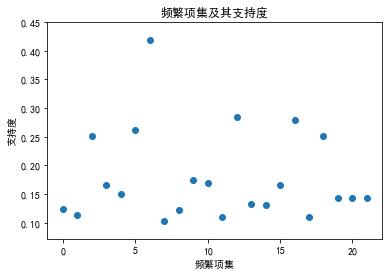

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

#plt.rcParams['figure.figsize'] = (8, 6)

print('-----------------------频繁项集及其支持度的散点图--------------------------')
frequenceItem = items_data['frequenceItem']
support = items_data['support']
x = range(len(frequenceItem))
#plt.xticks(x, frequenceItem, rotation=80)
plt.scatter(x, support)

# 设置title和x，y轴的label
plt.title("频繁项集及其支持度")
plt.xlabel("频繁项集")
plt.ylabel("支持度")

# 展示图片 *必加
plt.show()

### 3. 画出关联规则及其模型评估的散点图

-----------------------关联规则及其模型评估的散点图(图中横坐标对应关联规则)--------------------------


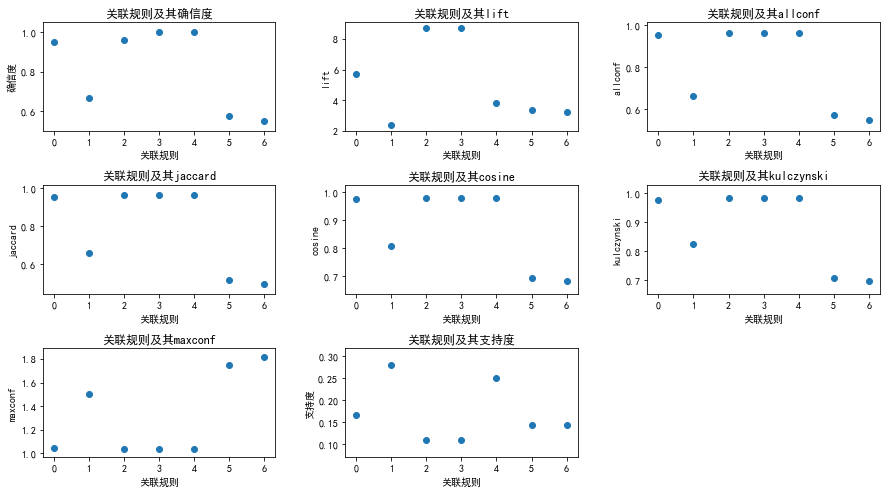

In [25]:
frequenceItem = rules_data['frequenceItem']
x = range(len(frequenceItem))

print('-----------------------关联规则及其模型评估的散点图(图中横坐标对应关联规则)--------------------------')
fig  = plt.figure(figsize=(15,8))
plt.subplots_adjust(wspace =0.3, hspace =0.5)
fig1 = fig.add_subplot(3,3,1)
confidence = rules_data['confidence']
#plt.xticks(x, frequenceItem, rotation=80)
fig1.scatter(x, confidence)
fig1.set_title('关联规则及其确信度')
plt.xlabel('关联规则')
plt.ylabel('确信度')

fig2 = fig.add_subplot(3,3,2)
lift = rules_data['lift']
fig2.scatter(x, lift)
fig2.set_title('关联规则及其lift')
plt.xlabel('关联规则')
plt.ylabel('lift')

#'allconf', 'jaccard', 'cosine', 'kulczynski', 'maxconf'
fig3 = fig.add_subplot(3,3,3)
allconf = rules_data['allconf']
fig3.scatter(x, allconf)
fig3.set_title('关联规则及其allconf')
plt.xlabel('关联规则')
plt.ylabel('allconf')

fig4 = fig.add_subplot(3,3,4)
jaccard = rules_data['jaccard']
fig4.scatter(x, jaccard)
fig4.set_title('关联规则及其jaccard')
plt.xlabel('关联规则')
plt.ylabel('jaccard')

fig5 = fig.add_subplot(3,3,5)
cosine = rules_data['cosine']
fig5.scatter(x, cosine)
fig5.set_title('关联规则及其cosine')
plt.xlabel('关联规则')
plt.ylabel('cosine')

fig6 = fig.add_subplot(3,3,6)
kulczynski = rules_data['kulczynski']
fig6.scatter(x, kulczynski)
fig6.set_title('关联规则及其kulczynski')
plt.xlabel('关联规则')
plt.ylabel('kulczynski')

fig7 = fig.add_subplot(3,3,7)
maxconf = rules_data['maxconf']
fig7.scatter(x, maxconf)
fig7.set_title('关联规则及其maxconf')
plt.xlabel('关联规则')
plt.ylabel('maxconf')

fig8 = fig.add_subplot(3,3,8)
support = rules_data['support']
fig8.scatter(x, support)
fig8.set_title('关联规则及其支持度')
plt.xlabel('关联规则')
plt.ylabel('支持度')

plt.show()